In [2]:
#IMPORTS
import qiskit
from qiskit import *
import matplotlib as mpl
from random import choice, randint 
from qiskit.tools.monitor import job_monitor
import qiskit_ibm_provider


In [4]:
IBMQ.save_account('YOUR_IBMQ_KEY', overwrite=True)

In [11]:
def Oracle(circuit,n):     #begin our function

    oracle_type = choice(['Constant0','Constant1','Balanced'])
    
    circuit.barrier()

    if oracle_type == 'Balanced':

        #randomly flip qubits for 0 and 1 groups
        flipGates = randint(0,(2**n)-1)    #random binary num between 0 and 7
        flipGates = format(flipGates, '0'+str(n)+'b') #convert to binary string

        for qbit in range(0,len(flipGates)):   #iterate through flipGates
            if flipGates[qbit] == '1':
                circuit.x(qbit)     #flip qubit if necessary

        for qbit in range(0,n):    #CX Gate controlled on every query qubit
            circuit.cx(qbit,n)   #and targeting auxiliary qubit

        for qbit in range(0,len(flipGates)):   #unflip qubits so output reveals nothing except
            if flipGates[qbit] == '1':         #what the original input was
                circuit.x(qbit)


    elif oracle_type == 'Constant0':
        circuit.z(n)    #flip Auxiliary
    elif oracle_type == 'Constant1':
        pass

    circuit.barrier()
    return circuit, oracle_type

In [12]:
#input
n = 3    #the size of our Query, NOT including the Auxiliary
circuit = qiskit.QuantumCircuit(n+1,n+1)   #create circuit including Auxiliary qubit & bit

for i in range(0,n):    #place Query in superposition
    circuit.h(i)

circuit.x(n)    #flip Auxiliary
circuit.h(n)    #put into |-> state as preparation for Phase Kickback


In [13]:
#oracle
circuit, oracle_type = Oracle(circuit,n)


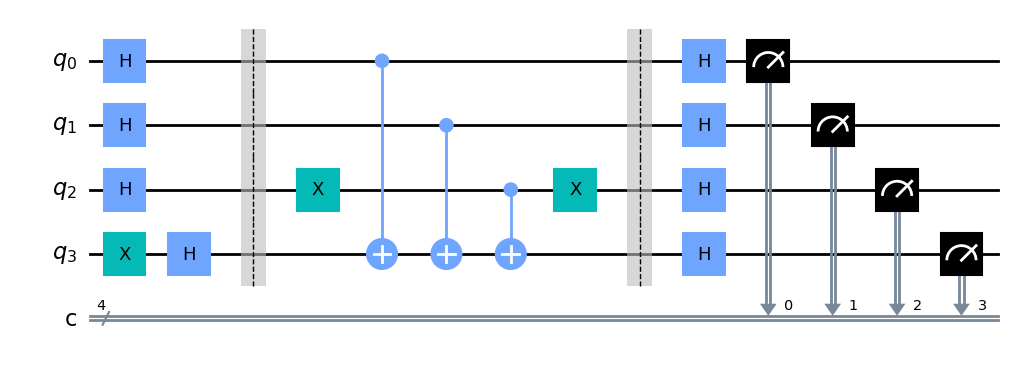

In [14]:
#output
for qbit in range(0,n+1):
    circuit.h(qbit)    #apply Hadamard to each qubit
    circuit.measure(qbit,qbit)    #measure qubit onto respective bit

circuit.draw('mpl')

In [15]:
#simulation
simulator = qiskit.BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(circuit, simulator, shots=1, memory=True)
result = job.result()
measurements = result.get_memory()[0]   #e.g '0000'

In [16]:
#Final Answer
query_state = measurements[-1]
if query_state == '1':
    guess = 'Balanced'
else:   #constant query
    aux_output = measurements[0]
    if aux_output == '1':
        guess = 'Constant1'
    else:
        guess = 'Constant0'
        
print('Prediction:')
print(guess)
print("")
print('Truth:')
print(oracle_type)

print("")
if guess == oracle_type:
    print("Answer is Correct!")

Prediction:
Balanced

Truth:
Balanced

Answer is Correct!


In [20]:
IBMQ.load_account()  
provider = IBMQ.get_provider(hub = 'ibm-q')
device = provider.get_backend('ibmq_quito')

In [21]:
job = execute(circuit,backend = device,shots = 100)


In [22]:
print(job.job_id())
job.status()

ci72rgg7s2lildo53iq0


<JobStatus.QUEUED: 'job is queued'>

In [ ]:
result = job.result()


In [ ]:
plot_histogram(result.get_counts(circuit))